<a href="https://colab.research.google.com/github/srinath116/brain-tumor-classification/blob/master/tflm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
import keras
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from sklearn.model_selection import KFold
img_width, img_height = 256, 256
kf = KFold(n_splits=5,random_state=None, shuffle=True)

batch_size = 50
epochs = 10

Using TensorFlow backend.


In [0]:
from keras import applications

In [0]:
img_width=256
img_height=256
model = applications.inception_v3.InceptionV3(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))

In [0]:
ACCURACY_THRESHOLD = 0.80

class myCallback(keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('val_acc') > ACCURACY_THRESHOLD):
			print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))
			self.model.stop_training = True

# Instantiate a callback object
callbacks = myCallback()


In [0]:
from keras import regularizers
for layer in model.layers:
    layer.trainable = False
x=Flatten()(model.get_output_at(-1))
x = Dense(1000, activation='relu',input_shape=model.output_shape[1:],kernel_regularizer=regularizers.l2(0.001))(x)

predictions = Dense(3, activation="softmax",name='output')(x)

# creating the final model 

model_final = Model(inputs=model.input,output=predictions)
adamopt=optimizers.Adam(0.0003)
# compile the model 

model_final.compile(loss=keras.losses.categorical_crossentropy, optimizer=adamopt, metrics=["accuracy"])
model_final.summary()



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 127, 127, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 127, 127, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`
  # This is added back by InteractiveShellApp.init_path()


In [0]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os 
from zipfile import ZipFile
base_path="/content/drive/My Drive/tuber_data.zip";

with ZipFile(base_path) as z:
    z.extractall()

In [0]:
import numpy as np
# example of converting an image with the Keras API
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
# load the image

# convert to numpy array
x= np.zeros((3061, 256, 256, 3))
y= np.zeros((3061, 1))
final_index = 0
for i in range(1,4):
  print(i)
  for index, image in enumerate(os.listdir('./data_'+str(i))):
        img = load_img('./data_'+str(i)+"/"+image)
        temp=img_to_array(img)/255
        if temp.shape[0] == 256:
          x[index] = temp
          y[index] = i
          # print(temp.shape)
  final_index += index
print(final_index)


1
2
3
3061


In [0]:
from sklearn.preprocessing import OneHotEncoder 
  
# creating one hot encoder object with categorical feature 0 
# indicating the first column 
onehotencoder = OneHotEncoder(categorical_features = [0]) 
y = onehotencoder.fit_transform(y).toarray() 
print(y.shape,x.shape)

(3061, 3) (3061, 256, 256, 3)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:451: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=None,shuffle=True)

del x,y
# model_final.fit( x_train, y_train, batch_size=50,epochs=10,validation_data=(x_test,y_test))

In [0]:
kf.get_n_splits(x_train)

print(kf)     



KFold(n_splits=5, random_state=None, shuffle=True)


In [0]:
i=0;
for train_index, test_index in kf.split(x_train):
# for i in range(5):
  # x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
 
  print(i);
  history = model_final.fit( x_train[train_index], y_train[train_index], batch_size=50, epochs=10,validation_data=(x_train[test_index],y_train[test_index]),callbacks=[callbacks] )
  # history=model_final.fit( x_train, y_train, batch_size=50, epochs=10,validation_data=(x_test,y_test) )
  i=i+1;

0
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1836 samples, validate on 459 samples
Epoch 1/10
1836/1836 [==============================] - 16s 9ms/step - loss: 3.1864 - acc: 0.8818 - val_loss: 10.7389 - val_acc: 0.4292
Epoch 2/10
1836/1836 [==============================] - 7s 4ms/step - loss: 2.5130 - acc: 0.9395 - val_loss: 11.0901 - val_acc: 0.3878
Epoch 3/10
1836/1836 [==============================] - 7s 4ms/step - loss: 3.1297 - acc: 0.8965 - val_loss: 11.0265 - val_acc: 0.4031
Epoch 4/10
1836/1836 [==============================] - 7s 4ms/step - loss: 4.1046 - acc: 0.8322 - val_loss: 10.6117 - val_acc: 0.4248
Epoch 5/10
1836/1836 [==============================] - 7s 4ms/step - loss: 2.8912 - acc: 0.9009 - val_loss: 12.9621 - val_acc: 0.2767
Epoch 6/10
1836/1836 [==============================] - 7s 4ms/step - loss: 3.8563 - acc: 0.8382 - val_loss: 12.8466 - val_acc: 0.2767
Epoch 7/10
1836/1836 [======================

In [0]:
scores= model_final.evaluate(x=x_test,y=y_test)

766/766 [==============================] - 3s 4ms/step


In [0]:
print("%s: %.2f%%" % (model_final.metrics_names[1], scores[1]*100))

acc: 96.74%


In [0]:
print(model_final.metrics_names)

['loss', 'acc']


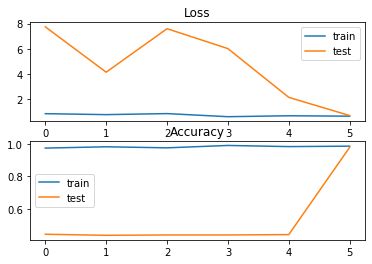

In [0]:
from matplotlib import pyplot
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
yhat_classes = model_final.predict(x_test, verbose=0)

In [0]:
y_predclasses=np.argmax(yhat_classes,axis=1)

In [0]:
y_actual=np.argmax(y_test,axis=1)

In [0]:
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_predclasses, y_actual, target_names=target_names))


              precision    recall  f1-score   support

     class 0       1.00      0.97      0.99       414
     class 1       0.84      0.97      0.90       112
     class 2       0.98      0.95      0.97       240

    accuracy                           0.97       766
   macro avg       0.94      0.97      0.95       766
weighted avg       0.97      0.97      0.97       766



In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
!cat /proc/cpuinfo


processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache size	: 46080 KB
physical id	: 0
siblings	: 4
core id		: 0
cpu cores	: 2
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4600.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	:

In [0]:
!cat /proc/gpuinfo

cat: /proc/gpuinfo: No such file or directory
